<a href="https://colab.research.google.com/github/39minutes/IDS-2025/blob/main/IDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Окружение готово!

Скачиваем NSL-KDD...
data/train.csv      100%[===================>]  13.94M  --.-KB/s    in 0.04s   
data/test.csv       100%[===================>]   2.52M  --.-KB/s    in 0.01s   
Данные скачаны!

Загружаем датасет...
Готово: 148,516 записей | Классов: 40
Классы: ['apache2' 'back' 'buffer_overflow' 'ftp_write' 'guess_passwd'
 'httptunnel' 'imap' 'ipsweep' 'land' 'loadmodule' 'mailbomb' 'mscan'
 'multihop' 'named' 'neptune'] ...

Устройство: cpu

Запуск обучения LSTM...
  Эпоха 4/12 завершена
  Эпоха 8/12 завершена
  Эпоха 12/12 завершена

РЕЗУЛЬТАТЫ LSTM (ГИБРИДНАЯ IDS)
                 precision    recall  f1-score   support

        apache2     0.9012    0.9932    0.9450       147
           back     0.8245    1.0000    0.9038       263
buffer_overflow     0.0843    0.7000    0.1505        10
      ftp_write     0.0588    0.5000    0.1053         2
   guess_passwd     0.2701    0.9416    0.4198       257
     httptunnel     0.5098    0.9630    0.6667        27
   

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/me

  Эпоха 10 → MSE: 0.0035794
  Эпоха 20 → MSE: 0.0021179
  Эпоха 30 → MSE: 0.0016478
  Эпоха 40 → MSE: 0.0014079
  Эпоха 50 → MSE: 0.0013236
  Эпоха 60 → MSE: 0.0012434

Порог аномалий: 0.018078

Модели и порог сохранены!



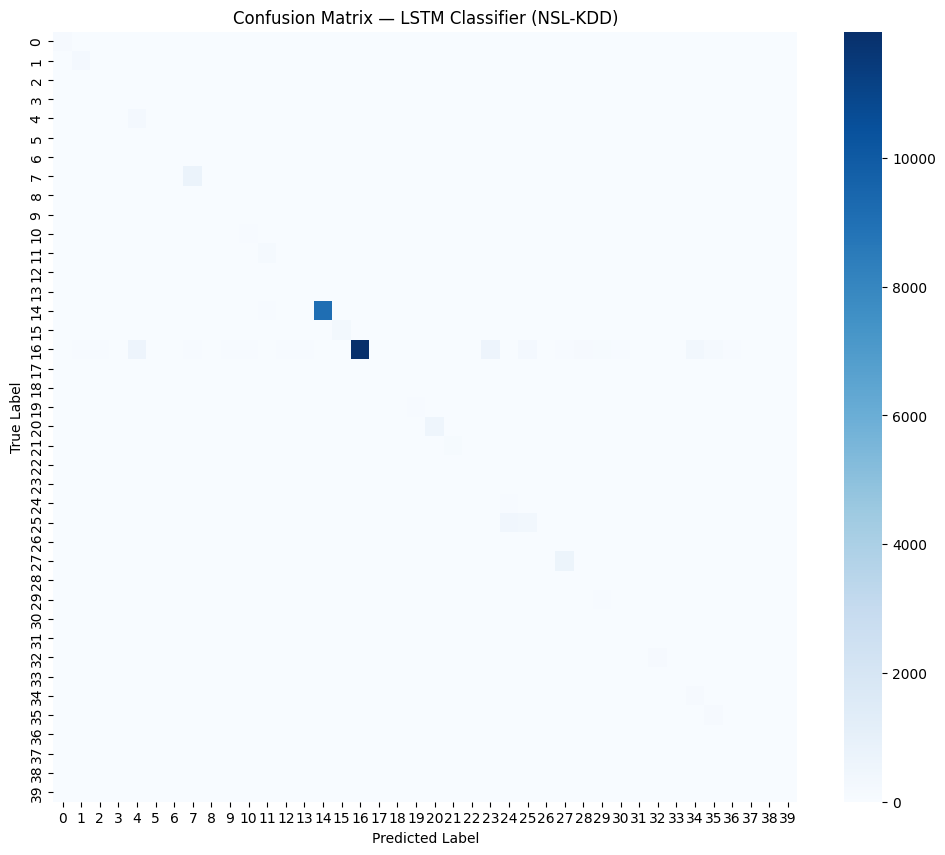


Тестирование гибридной модели в реальном времени:

     1. Атака: rootkit         | Аномалия: НЕТ | MSE: 0.00022 (порог 0.01808) → Правда: normal
  1001. Атака: neptune         | Аномалия: ДА | MSE: 0.13100 (порог 0.01808) → Правда: neptune
  5001. Атака: neptune         | Аномалия: ДА | MSE: 0.13055 (порог 0.01808) → Правда: neptune
 10001. Атака: satan           | Аномалия: НЕТ | MSE: 0.00129 (порог 0.01808) → Правда: normal
 25001. Атака: nmap            | Аномалия: ДА | MSE: 0.02977 (порог 0.01808) → Правда: nmap


In [8]:

# ЯЧЕЙКА 1 — Подготовка окружения
!mkdir -p data models
!pip install -q scapy imbalanced-learn joblib 2>/dev/null
print("Окружение готово!\n")

# ЯЧЕЙКА 2 — Скачивание NSL-KDD (рабочие ссылки 2025)
print("Скачиваем NSL-KDD...")
!wget -q --show-progress -O data/train.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.csv
!wget -q --show-progress -O data/test.csv https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.csv
print("Данные скачаны!\n")

# ЯЧЕЙКА 3 — Загрузка и полная предобработка
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import joblib

print("Загружаем датасет...")
train = pd.read_csv('data/train.csv', header=None)
test  = pd.read_csv('data/test.csv', header=None)
df = pd.concat([train, test], ignore_index=True)

columns = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot',
           'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
           'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
           'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate',
           'srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate',
           'dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
           'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
           'dst_host_srv_rerror_rate','label','difficulty']

df.columns = columns
df = df.drop('difficulty', axis=1)

# Кодирование категориальных признаков
le_protocol = LabelEncoder(); df['protocol_type'] = le_protocol.fit_transform(df['protocol_type'])
le_service  = LabelEncoder(); df['service']      = le_service.fit_transform(df['service'])
le_flag     = LabelEncoder(); df['flag']         = le_flag.fit_transform(df['flag'])

# Метки атак
le_label = LabelEncoder()
y_all = le_label.fit_transform(df['label'])
X_raw = df.drop('label', axis=1).values.astype(np.float32)

# Масштабирование
scaler_lstm = StandardScaler()
X_lstm = scaler_lstm.fit_transform(X_raw)

scaler_ae = MinMaxScaler()
X_ae = scaler_ae.fit_transform(X_raw)

# Разделение на train/test
X_train_lstm, X_test_lstm, y_train, y_test = train_test_split(
    X_lstm, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Добавляем временную ось для LSTM: (samples, timesteps=1, features)
X_train_lstm = X_train_lstm.reshape(-1, 1, X_train_lstm.shape[1])
X_test_lstm  = X_test_lstm.reshape(-1, 1, X_test_lstm.shape[1])

# Сохраняем всё нужное
joblib.dump(scaler_lstm, 'models/scaler_lstm.pkl')
joblib.dump(scaler_ae,   'models/scaler_ae.pkl')
joblib.dump(le_label,    'models/label_encoder.pkl')

print(f"Готово: {len(df):,} записей | Классов: {len(le_label.classes_)}")
print("Классы:", le_label.classes_[:15], "...\n")

# ЯЧЕЙКА 4 — ОБУЧЕНИЕ LSTM + АВТОЭНКОДЕР (ИСПРАВЛЕНО!
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Устройство: {device}\n")

# =============== 1. LSTM КЛАССИФИКАТОР ===============
print("Запуск обучения LSTM...")

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

class LSTM_IDS(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 128, num_layers=2, batch_first=True, dropout=0.4)
        self.fc = nn.Linear(128, num_classes)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model_lstm = LSTM_IDS(X_train_lstm.shape[2], len(le_label.classes_)).to(device)

train_loader = DataLoader(TensorDataset(torch.tensor(X_train_lstm),
                                        torch.tensor(y_train, dtype=torch.long)),
                          batch_size=256, shuffle=True)

optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(weight=class_weights)

for epoch in range(12):
    model_lstm.train()
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        loss = criterion(model_lstm(x_batch), y_batch)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 4 == 0:
        print(f"  Эпоха {epoch+1}/12 завершена")

# Оценка LSTM
model_lstm.eval()
with torch.no_grad():
    preds = torch.argmax(model_lstm(torch.tensor(X_test_lstm, dtype=torch.float32).to(device)), dim=1).cpu().numpy()

# ИСПРАВЛЕНИЕ: берём только те классы, которые есть в y_test
present_classes = np.unique(np.concatenate([y_train, y_test]))
present_names = le_label.classes_[present_classes]

print("\n" + "="*60)
print("РЕЗУЛЬТАТЫ LSTM (ГИБРИДНАЯ IDS)")
print("="*60)
print(classification_report(y_test, preds,
                          labels=present_classes,
                          target_names=present_names,
                          digits=4))

# =============== 2. АВТОЭНКОДЕР (ТОЛЬКО НА НОРМАЛЬНОМ ТРАФИКЕ) ===============
print("\nОбучение автоэнкодера на нормальном трафике...")

# Только нормальные записи
normal_mask = (df['label'] == 'normal')
X_normal_ae = X_ae[normal_mask]
normal_tensor = torch.tensor(X_normal_ae, dtype=torch.float32).to(device)

ae_loader = DataLoader(normal_tensor, batch_size=256, shuffle=True)

class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64),  nn.ReLU(),
            nn.Linear(64, 32),   nn.ReLU(),
            nn.Linear(32, 16),   nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),   nn.ReLU(),
            nn.Linear(32, 64),   nn.ReLU(),
            nn.Linear(64, 128),  nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, input_size), nn.Sigmoid()
        )
    def forward(self, x):
        return self.decoder(self.encoder(x))

ae = Autoencoder(X_ae.shape[1]).to(device)
opt_ae = torch.optim.Adam(ae.parameters(), lr=0.0005)

print("Обучение автоэнкодера (60 эпох)...")
ae.train()
for epoch in range(60):
    epoch_loss = 0
    for batch in ae_loader:
        opt_ae.zero_grad()
        recon = ae(batch)
        loss = nn.MSELoss()(recon, batch)
        loss.backward()
        opt_ae.step()
        epoch_loss += loss.item()
    if (epoch+1) % 10 == 0:
        print(f"  Эпоха {epoch+1:2d} → MSE: {epoch_loss/len(ae_loader):.7f}")

# Порог на нормальных данных
ae.eval()
with torch.no_grad():
    recon = ae(normal_tensor)
    mse_vals = torch.mean((recon - normal_tensor)**2, dim=1)
    threshold = (mse_vals.mean() + 3 * mse_vals.std()).item()

print(f"\nПорог аномалий: {threshold:.6f}")

# Сохранение моделей
torch.save(model_lstm.state_dict(), 'models/lstm_final.pth')
torch.save(ae.state_dict(), 'models/autoencoder_final.pth')
joblib.dump(threshold, 'models/threshold.pkl')

print("\nМодели и порог сохранены!\n")

# ЯЧЕЙКА 5 — Графики и функция реального времени
import joblib
threshold = joblib.load('models/threshold.pkl')

cm = confusion_matrix(y_test, preds, labels=present_classes)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap='Blues', fmt='d')
plt.title('Confusion Matrix — LSTM Classifier (NSL-KDD)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

def predict_hybrid(raw_vector):
    # raw_vector — np.array из 41 числового признака
    raw_vector = raw_vector.reshape(1, -1)

    # LSTM
    x_lstm = scaler_lstm.transform(raw_vector)
    x_lstm = torch.tensor(x_lstm.reshape(1,1,-1), dtype=torch.float32).to(device)

    # Autoencoder
    x_ae = scaler_ae.transform(raw_vector)
    x_ae = torch.tensor(x_ae, dtype=torch.float32).to(device)

    model_lstm.eval()
    ae.eval()
    with torch.no_grad():
        pred_class = torch.argmax(model_lstm(x_lstm)).item()
        attack_name = le_label.inverse_transform([pred_class])[0]

        recon = ae(x_ae)
        mse = torch.mean((x_ae - recon)**2).item()
        is_anomaly = "ДА" if mse > threshold else "НЕТ"

    return f"Атака: {attack_name:15} | Аномалия: {is_anomaly} | MSE: {mse:.5f} (порог {threshold:.5f})"

print("\nТестирование гибридной модели в реальном времени:\n")
for i in [0, 1000, 5000, 10000, 25000]:
    sample = df.drop('label', axis=1).iloc[i].values
    true_label = df['label'].iloc[i]
    print(f"{i+1:6}. {predict_hybrid(sample)} → Правда: {true_label}")

